## Bibliotecas

In [ ]:
%pip install dlib

In [ ]:
import os
import shutil
import random
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from scipy.stats import shapiro

## Detección y visualización de microexpresiones usando landmarks faciales con dlib

### Configuración del modelo de detección
Usamos el modelo **shape_predictor_68_face_landmarks.dat** de la librería dlib, la cual es una biblioteca de C++ y disponible en Python especializada en visión por computadora y machine learning. Además es compatible con otras bibliotecas como OpenCV (cv2).

In [ ]:
predictor_path = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

### Función para obtener landmarks

In [ ]:
def obtener_landmarks(ruta_imagen):
    img = cv2.imread(ruta_imagen)
    gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convertir la imagen (img) a escala de grises
    rostros = detector(gris, 1)  # detecta los rostros presentes en la imagen
    if len(rostros) == 0:
        return img, None  # si no se detecta ningun rostro se regresa la imagen

    forma = predictor(gris, rostros[0])  # detectar los landmarks del primer rostro encontrado
    coordenadas = np.array([(p.x, p.y) for p in forma.parts()])  # convertir los puntos en un arreglo de coordenadas
    return img, coordenadas  # regresa la imagen original y las coords de los landmarks

### Función para extraer las distancias normalizadas

El modelo **shape_predictor_68_face_landmarks.dat** etiqueta 68 puntos clave en la cara de la siguiente manera:

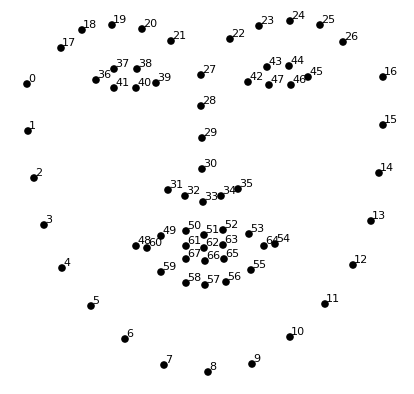

In [ ]:
def extraer_distancias(landmarks):
    ref = np.linalg.norm(landmarks[36] - landmarks[45])  # Distancia entre los ojos usada como referencia, debido a que varía poco con las expresiones faciales
    d = {}
    d["boca"] = np.linalg.norm(landmarks[62] - landmarks[66]) / ref  # Apertura vertical de la boca
    d["comisura"] = np.linalg.norm(landmarks[48] - landmarks[54]) / ref  # Distancia horizontal entre los extremos de la boca
    d["ojos"] = (np.linalg.norm(landmarks[38] - landmarks[40]) + np.linalg.norm(landmarks[44] - landmarks[46])) / (2 * ref)  # Apertura vertical de los ojos
    d["cejas"] = np.linalg.norm(landmarks[21] - landmarks[22]) / ref  # Distancia entre cejas
    d["nariz"] = np.linalg.norm(landmarks[31] - landmarks[35]) / ref  # Ancho de la nariz
    return d

### Función para analizar los cambios que hay en las microexpresiones

In [ ]:
def analizar_microexpresiones(ruta_carpeta):
    rutas_frames = sorted(glob.glob(os.path.join(ruta_carpeta, "*.jpg")))  # obtener todas las imagenes en la carpeta
    if len(rutas_frames) == 0:
        print("no hay imagenes")
        return

    distancias_por_frame = []
    imagenes = []
    deteccion_exitosa = []  # lista para saber si se detecto un rostro en cada imagen

    # recorrer todas las imagenes para detectar rostros y extraer distancias
    for ruta in rutas_frames:
        img, landmarks = obtener_landmarks(ruta)
        if landmarks is None:
            distancias_por_frame.append(None)  # si no hay rostro guardar none
            imagenes.append(cv2.cvtColor(cv2.imread(ruta), cv2.COLOR_BGR2RGB))
            deteccion_exitosa.append(False)  # indicar que no hubo deteccion
        else:
            # dibujar circulos en los landmarks detectados
            for (x, y) in landmarks:
                cv2.circle(img, (x, y), 2, (0, 255, 0), -1)
            imagenes.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # guardar las imagen con marcas
            distancias_por_frame.append(extraer_distancias(landmarks))  # guardar las distancias normalizadas
            deteccion_exitosa.append(True)  # indicar que si hubo deteccion

    # obtener los nombres de las distancias que se midieron
    etiquetas = list(distancias_por_frame[i].keys() for i in range(len(distancias_por_frame)) if distancias_por_frame[i] is not None)[0]
    valores = {k: [] for k in etiquetas}  # crear diccionario con listas vacias para cada tipo de distancia
    for d in distancias_por_frame:
        for k in etiquetas:
            valores[k].append(d[k] if d is not None else np.nan)  # llenar los valores o poner nan si no hubo deteccion

    # detectar picos o cambios bruscos en cada tipo de distancia
    picos = {}
    for k in etiquetas:
        serie = np.array(valores[k])  # convertir a arreglo numpy
        delta = np.abs(np.diff(serie))  # calcular cambio absoluto entre frames consecutivos
        umbral = np.nanstd(delta) * 2  # la función np.nanstd() calcula la desviación estándar de un arreglo ignorando los valores NaN (Not a Number).
        # se tomo ese umbral pq en una distribución normal, aproximadamente el 95% de los datos están dentro de ±2 desviaciones estándar del promedio.
        picos[k] = np.where(delta > umbral)[0]  # guardar indices donde el cambio fue mayor al umbral

    # mostrar las imagenes en bloques de diez para observar posibles microexpresiones
    total = len(imagenes)
    for inicio in range(0, total, 10):
        fin = min(inicio + 10, total)
        fig, axs = plt.subplots(1, fin - inicio, figsize=(15, 4))
        if fin - inicio == 1:
            axs = [axs]
        for i, idx in enumerate(range(inicio, fin)):
            axs[i].imshow(imagenes[idx])
            axs[i].axis('off')
            if not deteccion_exitosa[idx]:
                axs[i].set_title(f"frame {idx+1}\nsin rostro", fontsize=8)
            else:
                marcas = [k for k in etiquetas if idx in picos[k]]  # ver si este frame fue marcado como pico
                if marcas:
                    axs[i].set_title(f"frame {idx+1}\n{' + '.join(marcas)}", fontsize=8)
                else:
                    axs[i].set_title(f"frame {idx+1}", fontsize=8)
        plt.tight_layout()
        plt.show()
        if fin < total:
            input(f"mostrando frames {inicio+1} a {fin} presiona enter para continuar")

    # graficar la evolucion de las distancias para cada tipo de medida
    plt.figure(figsize=(12, 5))
    for k in etiquetas:
        plt.plot(valores[k], label=k)
        for p in picos[k]:
            plt.axvline(x=p+1, color='#faf495', linestyle='--', alpha=0.5)  # marcamos con lineas moradas los picos
    plt.title("distancias faciales normalizadas")
    plt.xlabel("frame")
    plt.ylabel("distancia normalizada")
    plt.legend()
    plt.grid(True)
    plt.show()

## Análisis de distancias de regiones clave (en una sola carpeta, es decir un video)

In [ ]:
analizar_microexpresiones("dataset/train/mentira/P28_mentira1")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
analizar_microexpresiones("dataset/train/verdad/P28_verdad2")

Output hidden; open in https://colab.research.google.com to view.

## Análisis en la base de datos (análisis general)

### Procesar dataset para obtener landmarks

In [ ]:
def procesar_dataset(ruta_base, salida_csv):
    datos = []

    for etiqueta_clase in ["verdad", "mentira"]:
      # clases: 0 verdad y 1 mentira
        clase = 0 if etiqueta_clase == "verdad" else 1
        ruta_clase = os.path.join(ruta_base, etiqueta_clase)
        carpetas = os.listdir(ruta_clase)

        for carpeta in tqdm(carpetas, desc=f"Procesando {etiqueta_clase}"):
            ruta_carpeta = os.path.join(ruta_clase, carpeta)
            imagenes = sorted(glob.glob(os.path.join(ruta_carpeta, "*.jpg")))

            for img_path in imagenes:
                _, landmarks = obtener_landmarks(img_path)
                if landmarks is not None:
                    dist = extraer_distancias(landmarks)
                    dist["frame_id"] = os.path.basename(img_path)
                    dist["etiqueta"] = clase
                    datos.append(dist)

    df = pd.DataFrame(datos)
    df.to_csv(salida_csv, index=False)

In [ ]:
ruta_dataset = "dataset/train"
salida_csv = "datos_entrenamiento.csv"
procesar_dataset(ruta_dataset, salida_csv)

Procesando mentira: 100%|██████████| 213/213 [55:18<00:00, 15.58s/it]


### Gráficas de caja y bigotes

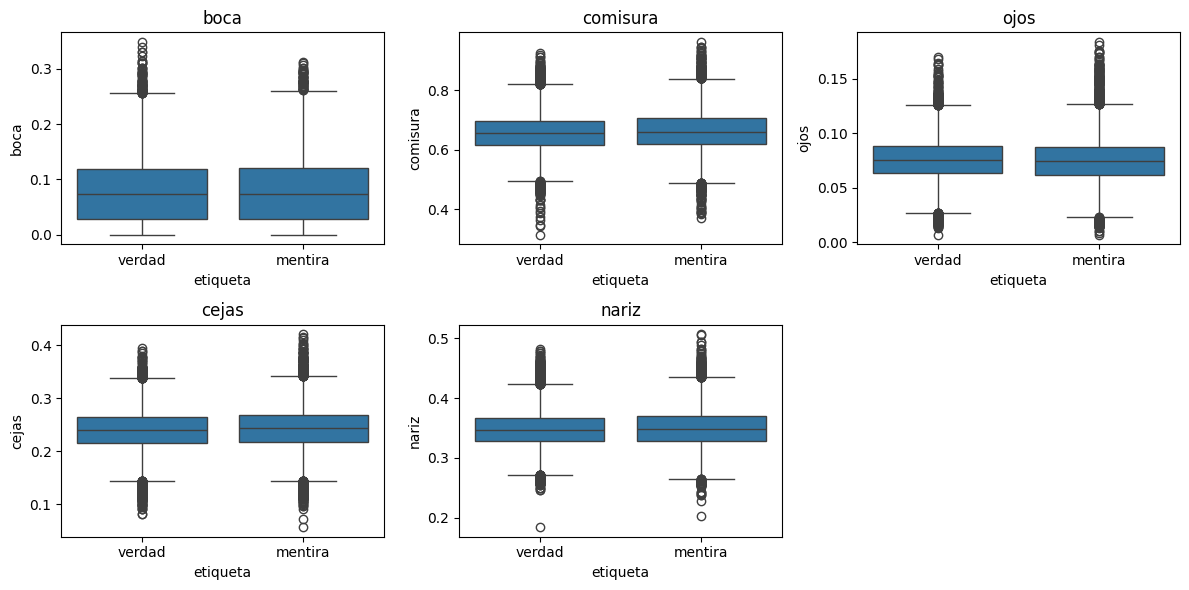

In [ ]:
df = pd.read_csv("datos_entrenamiento.csv")
# Renombrar clases para visualización
df["etiqueta"] = df["etiqueta"].map({0: "verdad", 1: "mentira"})

# Boxplot por zona facial
plt.figure(figsize=(12, 6))
for i, zona in enumerate(["boca", "comisura", "ojos", "cejas", "nariz"]):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x="etiqueta", y=zona, data=df)
    plt.title(zona)
plt.tight_layout()
plt.show()

#### Observaciones
Podemos observar lo siguiente:

- Boca

Las medianas son muy similares entre las etiquetas "verdad" y "mentira", pero en ambos casos se observa una gran cantidad de valores atípicos hacia arriba. La dispersión es ligeramente mayor en las mentiras, lo que sugiere una mayor variabilidad en la apertura de la boca cuando se miente.

- Comisura

Tanto en verdad como en mentira las distribuciones son similares, aunque en la etiqueta "mentira" se aprecian algunos valores extremos más alejados hacia ambos lados, esto puede interpretarse como mayor actividad en las comisuras de los labios, posiblemente derivada de sonrisas falsas.

Recordemos que desde un punto psicológico de las emociones, en las mentiras las personas a veces simulan expresiones (como sus sonrisas), pero los músculos de la boca y los ojos no se sincronizan como en una emoción genuina, es por eso que esto es un signo de mentira.

- Ojos

Hay una gran cantidad de valores atípicos hacia arriba en ambas etiquetas, estos se aprecian más en el caso de la mentira, lo que significa que hay una mayor apertura ocular, esto se asocia a emociones como sorpresa o incluso nerviosismo al mentir.

- Cejas

Ambos grupos muestran una distribución parecida, pero en las respuestas falsas se nota una ligera mayor elevación de la mediana y más dispersión hacia arriba. Esto sugiere que las cejas tienden a alzarse más durante las mentiras, lo cual puede ser interpretado como una manifestación de sorpresa fingida, duda o esfuerzo cognitivo.


---


Se concluye entonces que los patrones observados en la boca, comisura, ojos y cejas durante las respuestas clasificadas como mentiras muestran una mayor actividad emocional, además el hecho de que haya mayor apertura en los ojos y en la elevación de cejas durante las mentiras podrían ser indicios de una emoción repentina, reflejando un estado de mayor carga cognitiva al estar creando una historia que contar.  Al menos hasta este breve acercamiento al uso de nuestra base de datos, se apoya la idea de que la mentira provoca reacciones faciales más exageradas.